In [1]:
# Standard Python modules
import os, sys
import yaml
import glob
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

# matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
import cartopy.feature as cfeature

# extras
%matplotlib inline
from scipy.spatial import cKDTree
from shapely.geometry import Point

# import personal modules
# Path to modules
sys.path.append('../modules')
import nclcmaps as nclc
from plotter import draw_basemap

ERROR 1: PROJ: proj_create_from_database: Open of /cw3e/mead/projects/cwp140/scratch/dnash/miniconda3/envs/SEAK-clim/share/proj failed


In [2]:
# Set up paths
path_to_data = '../data/'
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures

In [3]:
def ckdnearest(gdA, gdB):
    '''
    Returns the distance and 'Name' of the nearest neighbor in gdB from each point in gdA
    from: https://gis.stackexchange.com/questions/222315/finding-nearest-point-in-other-geodataframe-using-geopandas
    
    Parameters
    ----------
    gdA : geopandas dataframe
        dataframe that has points that you are trying to find the nearest neighbor to
    gdB: geopandas dataframe
        dataframe that has points that you are trying to find the nearest neighbor of
        
    Returns
    -------
    gdf : geopandas dataframe
        df with distance and 'Name' of the nearest neighbor in gdB from each point in gdA
    '''
    nA = np.array(list(gdA.geometry.apply(lambda x: (x.x, x.y))))
    nB = np.array(list(gdB.geometry.apply(lambda x: (x.x, x.y))))
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdB_nearest = gdB.iloc[idx].drop(columns="geometry").reset_index(drop=True)
    gdf = pd.concat(
        [
            gdA.reset_index(drop=True),
            gdB_nearest,
            pd.Series(dist, name='dist')
        ], 
        axis=1)

    return gdf

In [4]:
## read the landslide data from NWS
fname = 'LSRs_24Dec2022_18Jan2023_CaliforniaWFOs.csv'
f = path_to_data + fname
df = pd.read_csv(f, header=0)

## read the CDEC station list
fname = path_to_data + 'cdec_nrt_stations_20230215.csv'
station_df = pd.read_csv(fname, header=0)
station_df = station_df[station_df['COUNTY'].notna()] # only keep rows where county is not-nan
station_df

## turn landslide df into geopandas df
gdfA = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Lon, df.Lat))
gdfB = gpd.GeoDataFrame(station_df, geometry=gpd.points_from_xy(station_df.LONGITUDE, station_df.LATITUDE))


In [8]:
## returns a new landslide df that has the closest station location information attached to it 
## includes the distance between the landslide location and station location
merged_df = ckdnearest(gdfA, gdfB)
merged_df

,Office,Report Time (Local WFO Timezone),Report Time (UTC Timezone),County,Location,ST,Event Type,Mag.,Source,Lat,...,ugcname,geometry,STATION,ID,ELEV,LATITUDE,LONGITUDE,COUNTY,OPERATOR AGENCY,dist
0,EKA,2022/12/26 20:09,2022/12/27 04:09,HUMBOLDT,3.5 N WILLOW CREEK,CA,DEBRIS FLOW,NaN,LAW ENFORCEMENT,40.93,...,Humboldt,POINT (-123.67000 40.93000),TRINITY RIVER AT HOOPA,HPA,330,41.049850,-123.673668,HUMBOLDT,USGS/DWR-DFM-Hydro-SMN,0.119906
1,EKA,2022/12/26 20:27,2022/12/27 04:27,HUMBOLDT,4 N HOOPA,CA,DEBRIS FLOW,NaN,LAW ENFORCEMENT,41.11,...,Humboldt,POINT (-123.67000 41.11000),TRINITY RIVER AT HOOPA,HPA,330,41.049850,-123.673668,HUMBOLDT,USGS/DWR-DFM-Hydro-SMN,0.060262
2,EKA,2022/12/26 20:40,2022/12/27 04:40,DEL NORTE,7 ENE GASQUET,CA,DEBRIS FLOW,NaN,LAW ENFORCEMENT,41.87,...,Del Norte,POINT (-123.84000 41.87000),OAK KNOLL,OKK,1940,41.833000,-123.833000,DEL NORTE,US Forest Service,0.037656
3,EKA,2022/12/26 21:30,2022/12/27 05:30,DEL NORTE,1 WSW GASQUET,CA,DEBRIS FLOW,NaN,LAW ENFORCEMENT,41.84,...,Del Norte,POINT (-123.98000 41.84000),GASQUET RANGER STATION,GAS,384,41.845161,-123.965103,DEL NORTE,USGS/DWR-DFM-Hydro-SMN,0.015766
4,HNX,2022/12/27 09:00,2022/12/27 17:00,MARIPOSA,1 NNW YOSEMITE NAT'L PA,CA,DEBRIS FLOW,NaN,PARK/FOREST SRVC,37.72,...,Mariposa,POINT (-119.68000 37.72000),FORESTA,X05,4580,37.693943,-119.744499,MARIPOSA,CA Dept of Water Resources/Flood Management,0.069564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,SGX,2023/01/16 06:32,2023/01/16 14:32,SAN DIEGO,1 E JULIAN,CA,DEBRIS FLOW,NaN,DEPT OF HIGHWAYS,33.08,...,San Diego,POINT (-116.56000 33.08000),JULIAN,JUL,4240,33.076000,-116.591003,SAN DIEGO,CA Dept of Forestry and Fire Protection,0.031260
85,SGX,2023/01/16 06:37,2023/01/16 14:37,SAN DIEGO,4 NE LAKESIDE,CA,DEBRIS FLOW,NaN,DEPT OF HIGHWAYS,32.89,...,San Diego,POINT (-116.85000 32.89000),EL CAPITAN RESERVOIR,ECR,800,32.882000,-116.806999,SAN DIEGO,San Diego County,0.043739
86,SGX,2023/01/16 06:51,2023/01/16 14:51,SAN DIEGO,1 SW PALOMAR MOUNTAIN,CA,DEBRIS FLOW,NaN,DEPT OF HIGHWAYS,33.31,...,San Diego,POINT (-116.89000 33.31000),OAK GROVE,OKG,2752,33.393002,-116.794998,SAN DIEGO,US Forest Service,0.126154
87,SGX,2023/01/16 06:58,2023/01/16 14:58,RIVERSIDE,7 WSW LAKE ELSINORE,CA,DEBRIS FLOW,NaN,DEPT OF HIGHWAYS,33.61,...,Riverside,POINT (-117.43000 33.61000),EL CARISO,ECA,3038,33.650002,-117.410004,RIVERSIDE,US Forest Service,0.044721


In [17]:
## write merged df to csv
merged_df.to_csv(path_to_out + 'NWS_landslides_CDEC_stations_dec22-jan23.csv')

In [9]:
## count how many times a station is close to a landslide
merged_df.groupby(merged_df['ID']).count()

,Office,Report Time (Local WFO Timezone),Report Time (UTC Timezone),County,Location,ST,Event Type,Mag.,Source,Lat,...,ugc,ugcname,geometry,STATION,ELEV,LATITUDE,LONGITUDE,COUNTY,OPERATOR AGENCY,dist
ID,,,,,,,,,,,,,,,,,,,,,
API,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
ARS,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
BCN,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
BDM,7,7,7,7,7,7,7,0,7,7,...,7,7,7,7,7,7,7,7,7,7
BEC,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
BHL,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
BNA,1,1,1,1,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
CAG,3,3,3,3,3,3,3,0,3,3,...,3,3,3,3,3,3,3,3,3,3
CKC,2,2,2,2,2,2,2,0,2,2,...,2,2,2,2,2,2,2,2,2,2


In [23]:
## BDM, CON, and VAL had 5-7 events
merged_df.loc[(merged_df['ID'] == 'VAL')]

,Office,Report Time (Local WFO Timezone),Report Time (UTC Timezone),County,Location,ST,Event Type,Mag.,Source,Lat,...,ugcname,geometry,STATION,ID,ELEV,LATITUDE,LONGITUDE,COUNTY,OPERATOR AGENCY,dist
64,SGX,2023/01/10 15:15,2023/01/10 23:15,SAN DIEGO,4 SW ESCONDIDO,CA,DEBRIS FLOW,NaN,DEPT OF HIGHWAYS,33.09,...,San Diego,POINT (-117.12000 33.09000),VALLEY CENTER,VAL,1370,33.239399,-117.014198,SAN DIEGO,CA Dept of Forestry and Fire Protection,0.183069
72,SGX,2023/01/14 16:43,2023/01/15 00:43,SAN DIEGO,4 NW RANCHO BERNARDO,CA,DEBRIS FLOW,NaN,DEPT OF HIGHWAYS,33.06,...,San Diego,POINT (-117.12000 33.06000),VALLEY CENTER,VAL,1370,33.239399,-117.014198,SAN DIEGO,CA Dept of Forestry and Fire Protection,0.208274
74,SGX,2023/01/14 21:46,2023/01/15 05:46,SAN DIEGO,3 NNE VALLEY CENTER,CA,DEBRIS FLOW,NaN,DEPT OF HIGHWAYS,33.26,...,San Diego,POINT (-117.01000 33.26000),VALLEY CENTER,VAL,1370,33.239399,-117.014198,SAN DIEGO,CA Dept of Forestry and Fire Protection,0.021024
75,SGX,2023/01/14 23:12,2023/01/15 07:12,SAN DIEGO,6 ESE ESCONDIDO,CA,DEBRIS FLOW,NaN,DEPT OF HIGHWAYS,33.10,...,San Diego,POINT (-116.99000 33.10000),VALLEY CENTER,VAL,1370,33.239399,-117.014198,SAN DIEGO,CA Dept of Forestry and Fire Protection,0.141484
76,SGX,2023/01/15 00:47,2023/01/15 08:47,SAN DIEGO,4 ESE VALLEY CENTER,CA,DEBRIS FLOW,NaN,DEPT OF HIGHWAYS,33.20,...,San Diego,POINT (-116.97000 33.20000),VALLEY CENTER,VAL,1370,33.239399,-117.014198,SAN DIEGO,CA Dept of Forestry and Fire Protection,0.059209
77,SGX,2023/01/15 00:54,2023/01/15 08:54,SAN DIEGO,5 ESE BONSALL,CA,DEBRIS FLOW,NaN,DEPT OF HIGHWAYS,33.26,...,San Diego,POINT (-117.14000 33.26000),VALLEY CENTER,VAL,1370,33.239399,-117.014198,SAN DIEGO,CA Dept of Forestry and Fire Protection,0.127478
80,SGX,2023/01/16 04:19,2023/01/16 12:19,SAN DIEGO,4 SSE VALLEY CENTER,CA,DEBRIS FLOW,NaN,DEPT OF HIGHWAYS,33.17,...,San Diego,POINT (-117.01000 33.17000),VALLEY CENTER,VAL,1370,33.239399,-117.014198,SAN DIEGO,CA Dept of Forestry and Fire Protection,0.069526


## Plot

In [11]:
# Set up projection
datacrs = ccrs.PlateCarree()  ## the projection the data is in
mapcrs = ccrs.Mercator() ## the projection you want your map displayed in

ext = [-125., -113., 32., 43.] # ext of CA

ext1 = [-120.5, -119.5, 34., 35.] # extent of Santa Barbara
ext2 = [-117.3, -116.9, 32.6, 33.1] # extent of San Diego
ext3 = [-120., -119.5, 36.8, 37.] # extent of Fresno
ext4 = [-117.5, -117., 34., 34.25] # extent of San Bernardino
ext_lst = [ext1, ext2, ext3, ext4]

## lats and lons of landslide points
xs1 = merged_df['Lon'].values
ys1 = merged_df['Lat'].values

## lats and lons of station points
xs2 = merged_df['LONGITUDE'].values
ys2 = merged_df['LATITUDE'].values

### State Map of NWS Landslide Locations

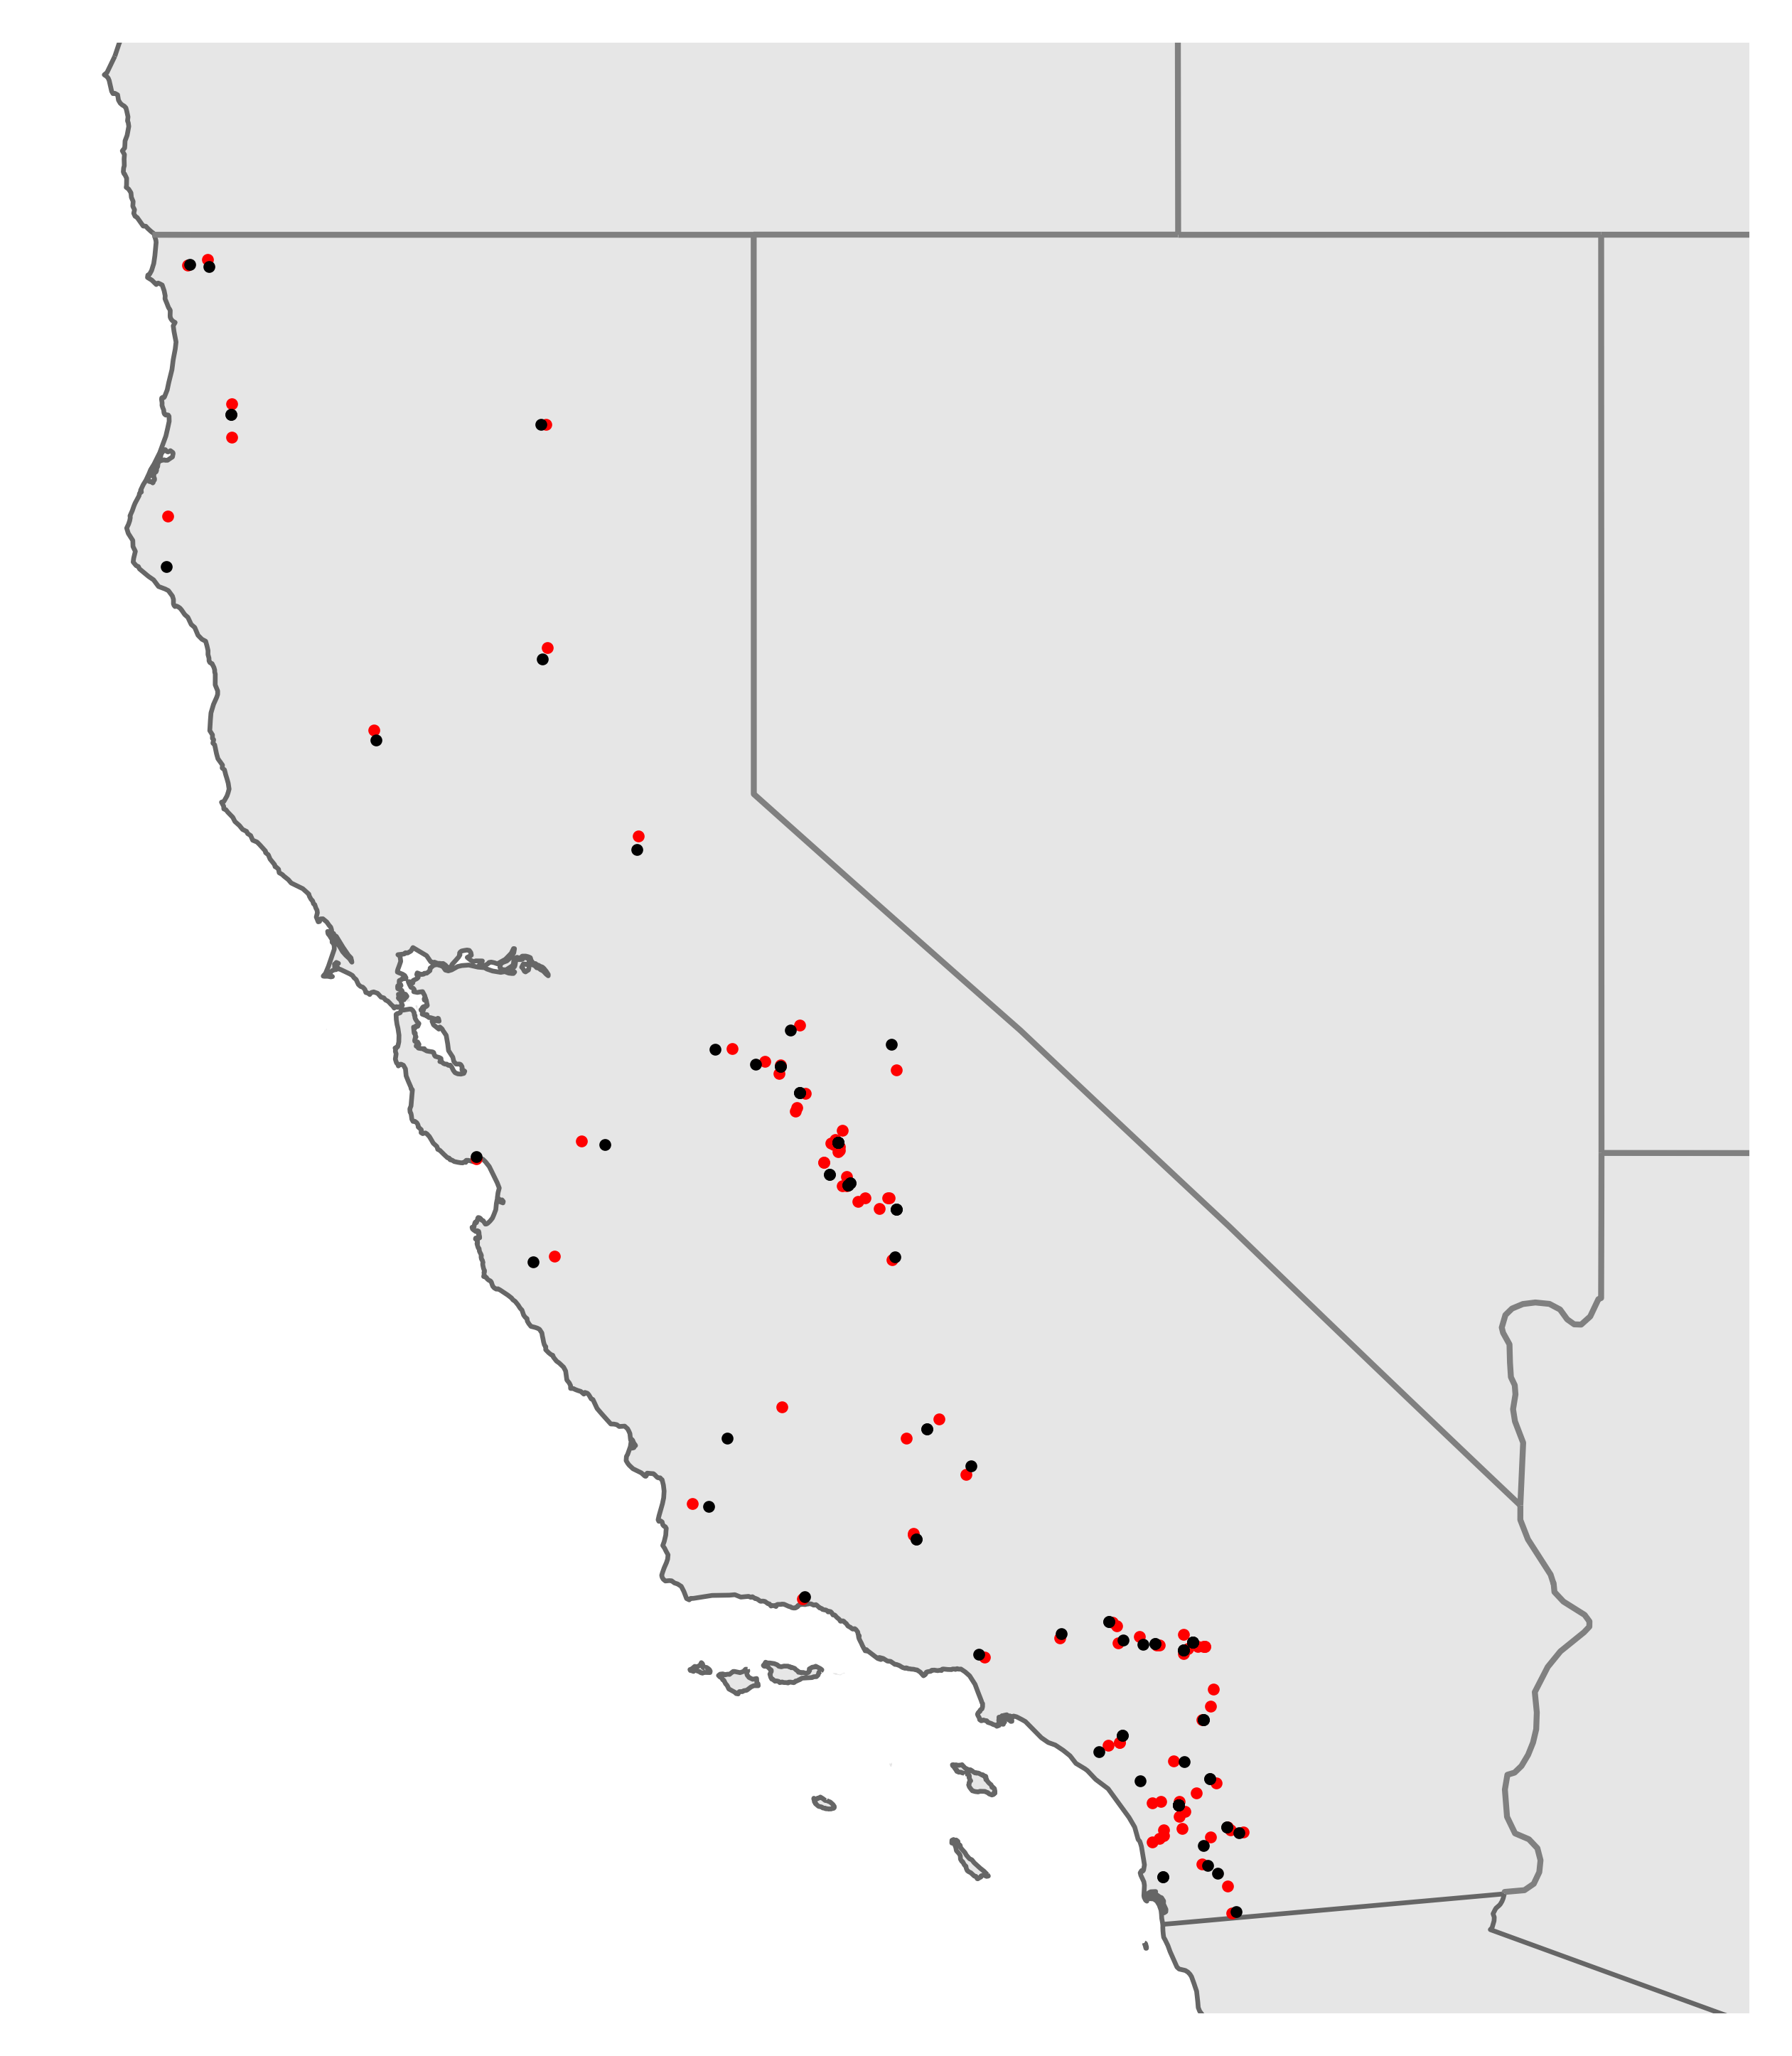

In [16]:
fig = plt.figure(figsize=(6.0 ,6.0))
fig.dpi = 600
fname = path_to_figs + 'landslide_loc_map'
fmt = 'png'


ax = plt.axes(projection=ccrs.Mercator())
ax.set_extent(ext, ccrs.PlateCarree())

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

# Add map features (continents and country borders)
ax.add_feature(cfeature.LAND, facecolor='0.9')      
ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)
ax.add_feature(states_provinces, edgecolor='gray')


## Plot the locations of landslides
# zip joins x and y coordinates in pairs
for x,y in zip(xs1,ys1):

    # Plot Location of pts
    ax.plot(x, y, 'ro', markersize=1, transform=datacrs, label="Landslide Locations")

for x,y in zip(xs2,ys2):

    # Plot Location of pts
    ax.plot(x, y, 'ko', markersize=1, transform=datacrs, label="CDEC NRT Station Location")

fig.patch.set_visible(False)
ax.axis('off')

# ax.legend(fontsize=20,
#           frameon=True,
#           loc=(1, .1),
#           title="LEGEND")

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi, transparent=True)
plt.show()
fig.clf()

/tmp/ipykernel_31715/3348903980.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(nrows, ncols, k+1, projection=mapcrs)


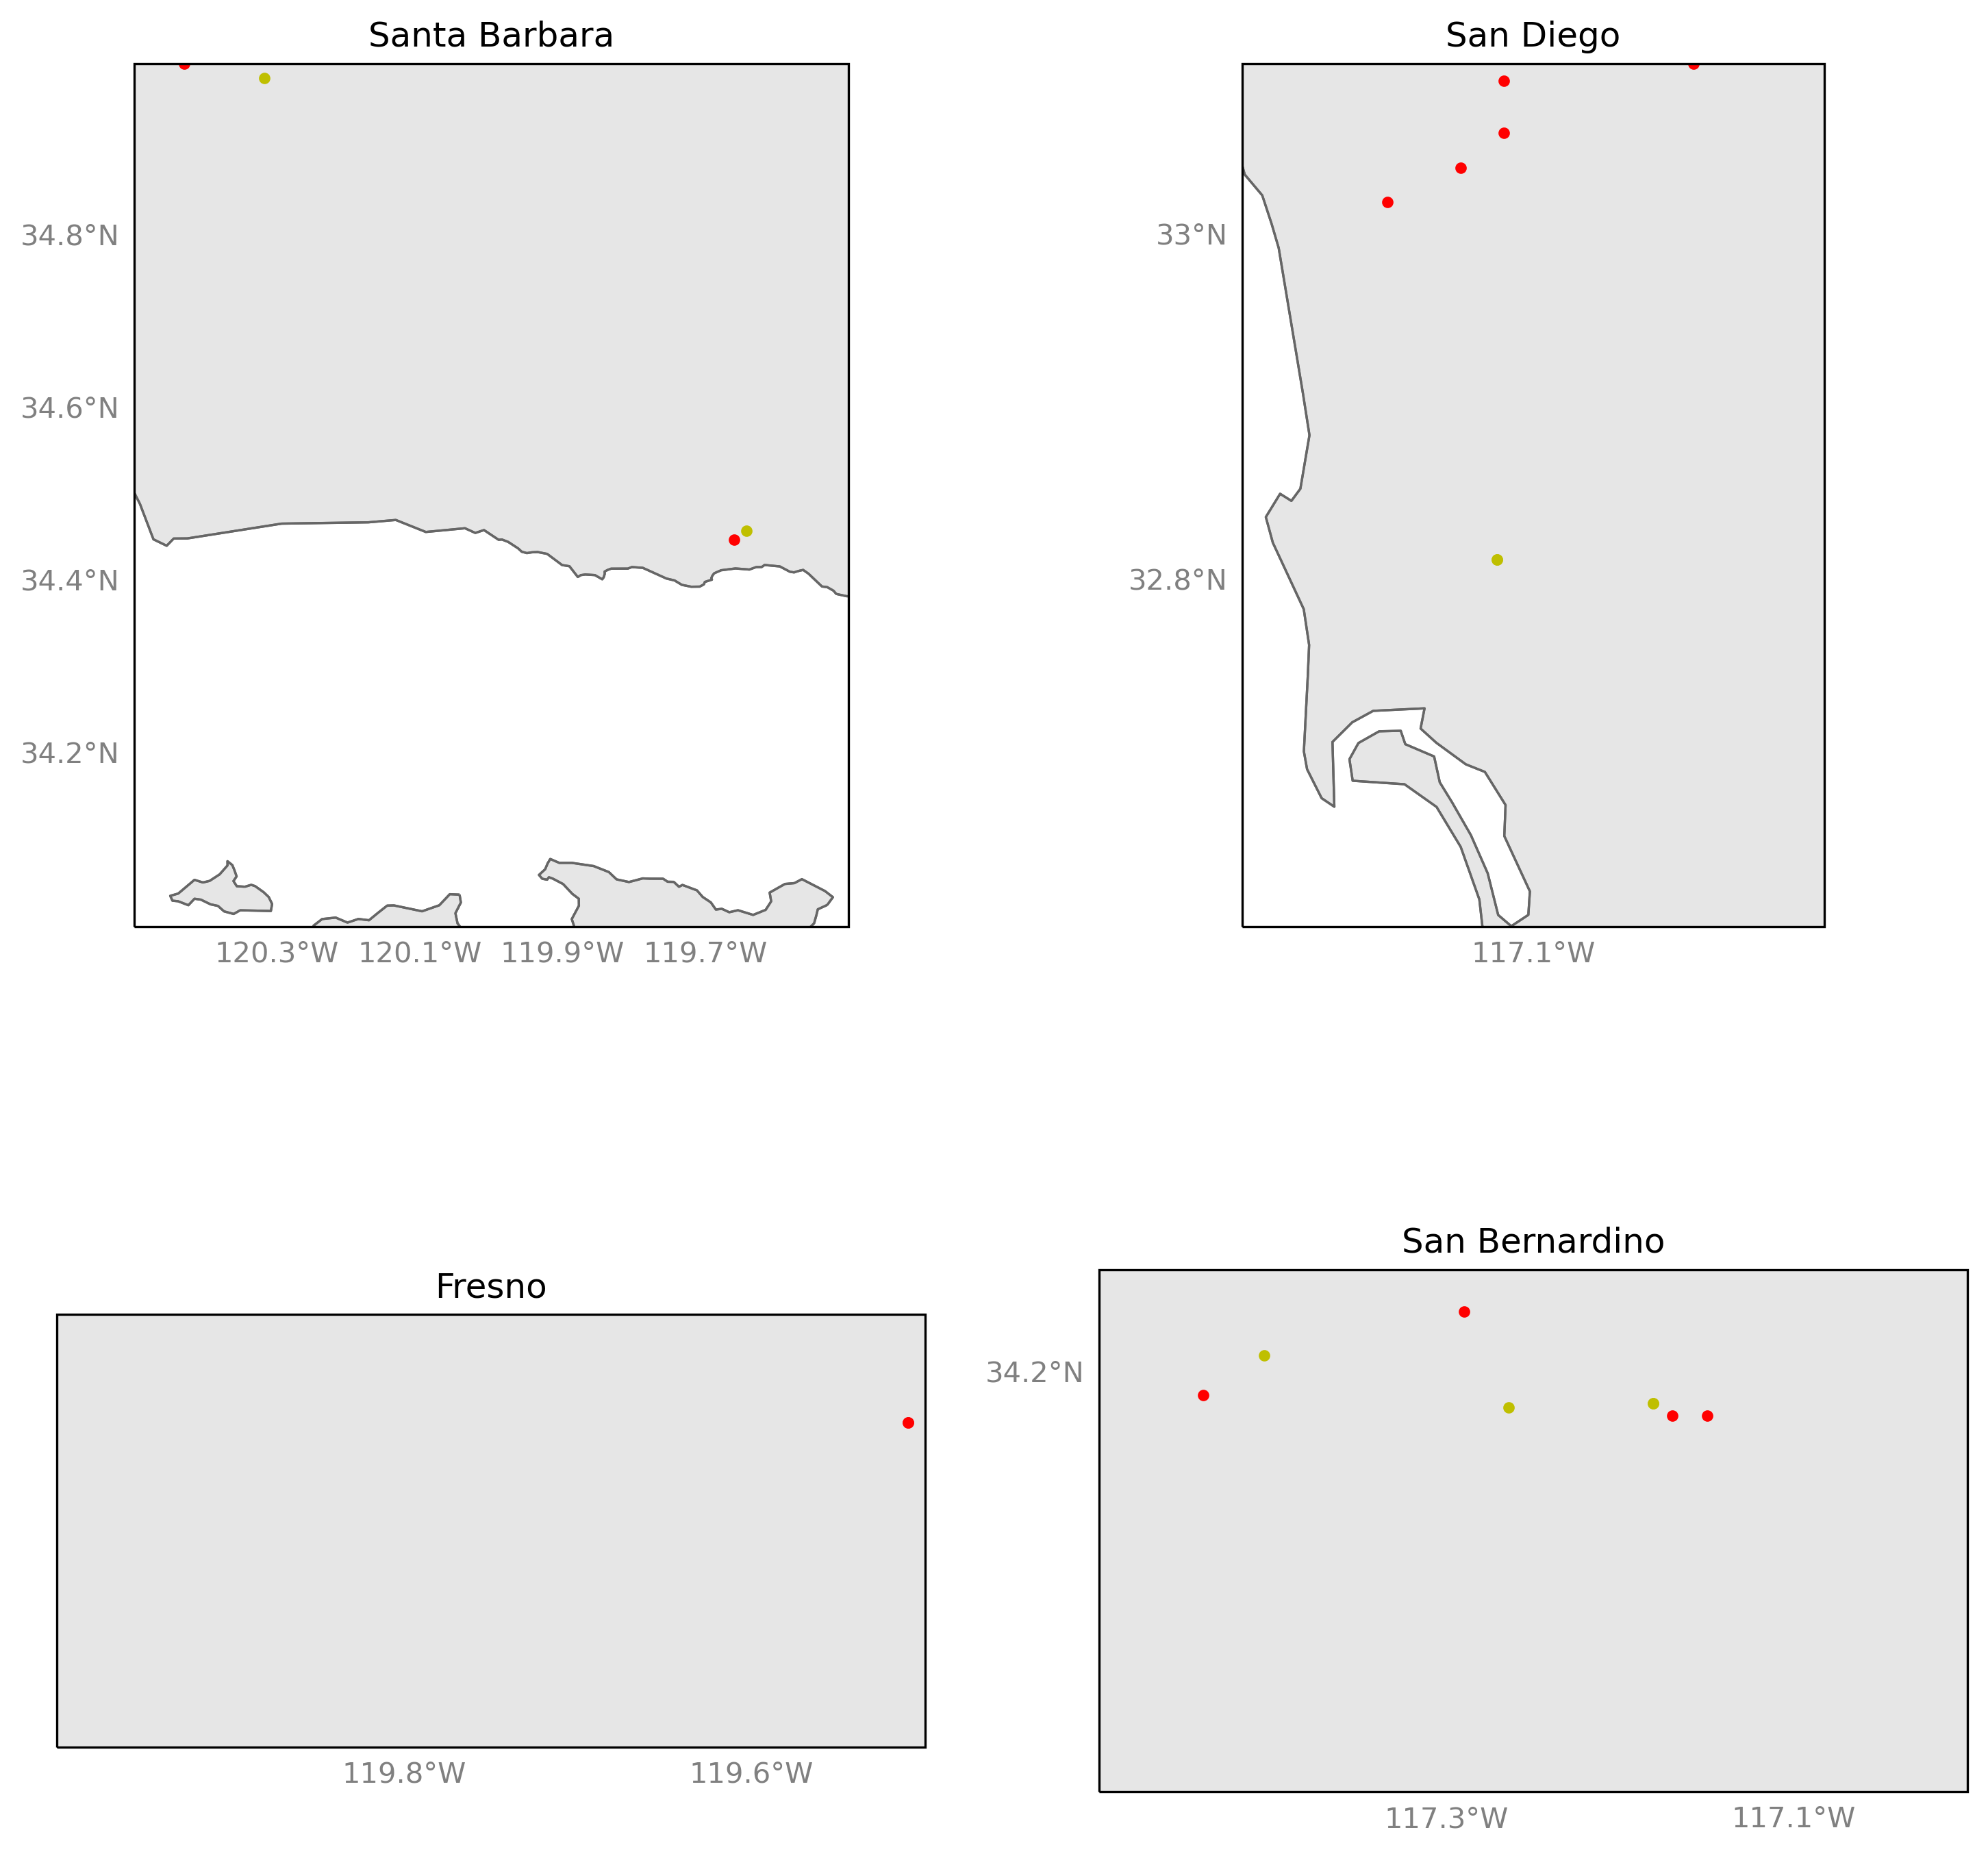

In [12]:
# Create figure
fig = plt.figure(figsize=(12, 12))
fig.dpi = 300
fname = path_to_figs + 'landslide_loc_cdec_stations'
fmt = 'png'

nrows = 2
ncols = 2

plt_lbl = ['Santa Barbara', 'San Diego', 'Fresno', 'San Bernardino']

# Set up Axes Grid
axes_class = (GeoAxes,dict(projection=mapcrs))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(nrows, ncols), axes_pad = 0.3,
                cbar_location='bottom', cbar_mode='single',
                cbar_pad=0.35, cbar_size='3%',label_mode='')

# for k, ax in enumerate(axgr):
for k in np.arange(nrows*ncols):
    ax = plt.subplot(nrows, ncols, k+1, projection=mapcrs)
    ## set lat lon gridlines
    lonmin, lonmax, latmin, latmax = ext_lst[k]
    dx = np.arange(lonmin,lonmax+0.2,0.2)
    dy = np.arange(latmin,latmax+0.2,0.2)
    ax = draw_basemap(ax, extent=ext_lst[k], xticks=dx, yticks=dy,left_lats=True, right_lats=False, bottom_lons=True)

    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural',
                                                    name='admin_1_states_provinces_lines',
                                                    scale='50m',
                                                    facecolor='none')

    # Add map features (continents and country borders)
    ax.add_feature(cfeature.LAND, facecolor='0.9')      
    ax.add_feature(cfeature.BORDERS, edgecolor='0.4', linewidth=0.8)
    ax.add_feature(cfeature.COASTLINE, edgecolor='0.4', linewidth=0.8)
    ax.add_feature(states_provinces, edgecolor='gray')

    ax.set_title(plt_lbl[k])
    ## Add points to map
    # need this to fix annotate transform
    transform = datacrs._as_mpl_transform(ax)
    # Plot Location of landslide pts
    # zip joins x and y coordinates in pairs
    for x,y in zip(xs1,ys1):
        # Plot Location of pts
        ax.plot(x, y, 'ro', markersize=3, transform=datacrs)
    # Plot Location of station pts
    for x,y in zip(xs2,ys2):
        # Plot Location of pts
        ax.plot(x, y, 'yo', markersize=3, transform=datacrs)
        

fig.savefig('%s.%s' %(fname, fmt), bbox_inches='tight', dpi=fig.dpi)

# Show
plt.show()